In [5]:
# imports from custom library
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Linear Supervised Learning Series

# Part 2: Logistic regression

In this post we describe a very particular form of nonlinear regression called *logistic regression* that is designed to deal with a very particular kind of dataset that is commonly dealt with in machine learning/deep learning: *two-class classification data*. 

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1.  Logistic regression

In this Section we set the scene for logistic regression by describing the problem setup and how linear regression - as well as reasonable extensions of it - naturally fail with such data.

## 1.1 The data

- Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.

- We will typically use $y_{p}\in\left\{ -1,\,+1\right\}$. 

- How can we perform regression on a dataset like this?

<p><img src= '../../../mlrefined_images/superlearn_images/Fig_4_10_new.png' width="80%" height="60%" alt=""/></p>

## 1.2  Trying to fit a discontinuous step function

- Lets look at a simple instance when $N = 1$.

- Intuitively fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results.

- Ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset. When $N = 1$ it is simply a line $y = w_0 + x_{\,}w_1$ composed with the $\text{sign}(\cdot)$ function

\begin{equation}
\text{sign}\left(w_0 + x_{\,}w_1 \right)
\end{equation}

- Remember that the $\text{sign}(\cdot)$ function is defined as $\text{sign}(\alpha) = 
\begin{cases}
+1 \,\,\,\,\,\text{if} \,\, \alpha > 0 \\
-1 \,\,\,\,\,\text{if} \,\, \alpha < 0 \\
\end{cases}$

- How do we tune the parameters of the line?

- We could try to take the lazy way out: *first* fit the line to the classification dataset via linear regression, then compose the line with the sign function to get a step function fit.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line first and taking the sign afterward fails to represent a two-class dataset well

<IPython.core.display.Javascript object>


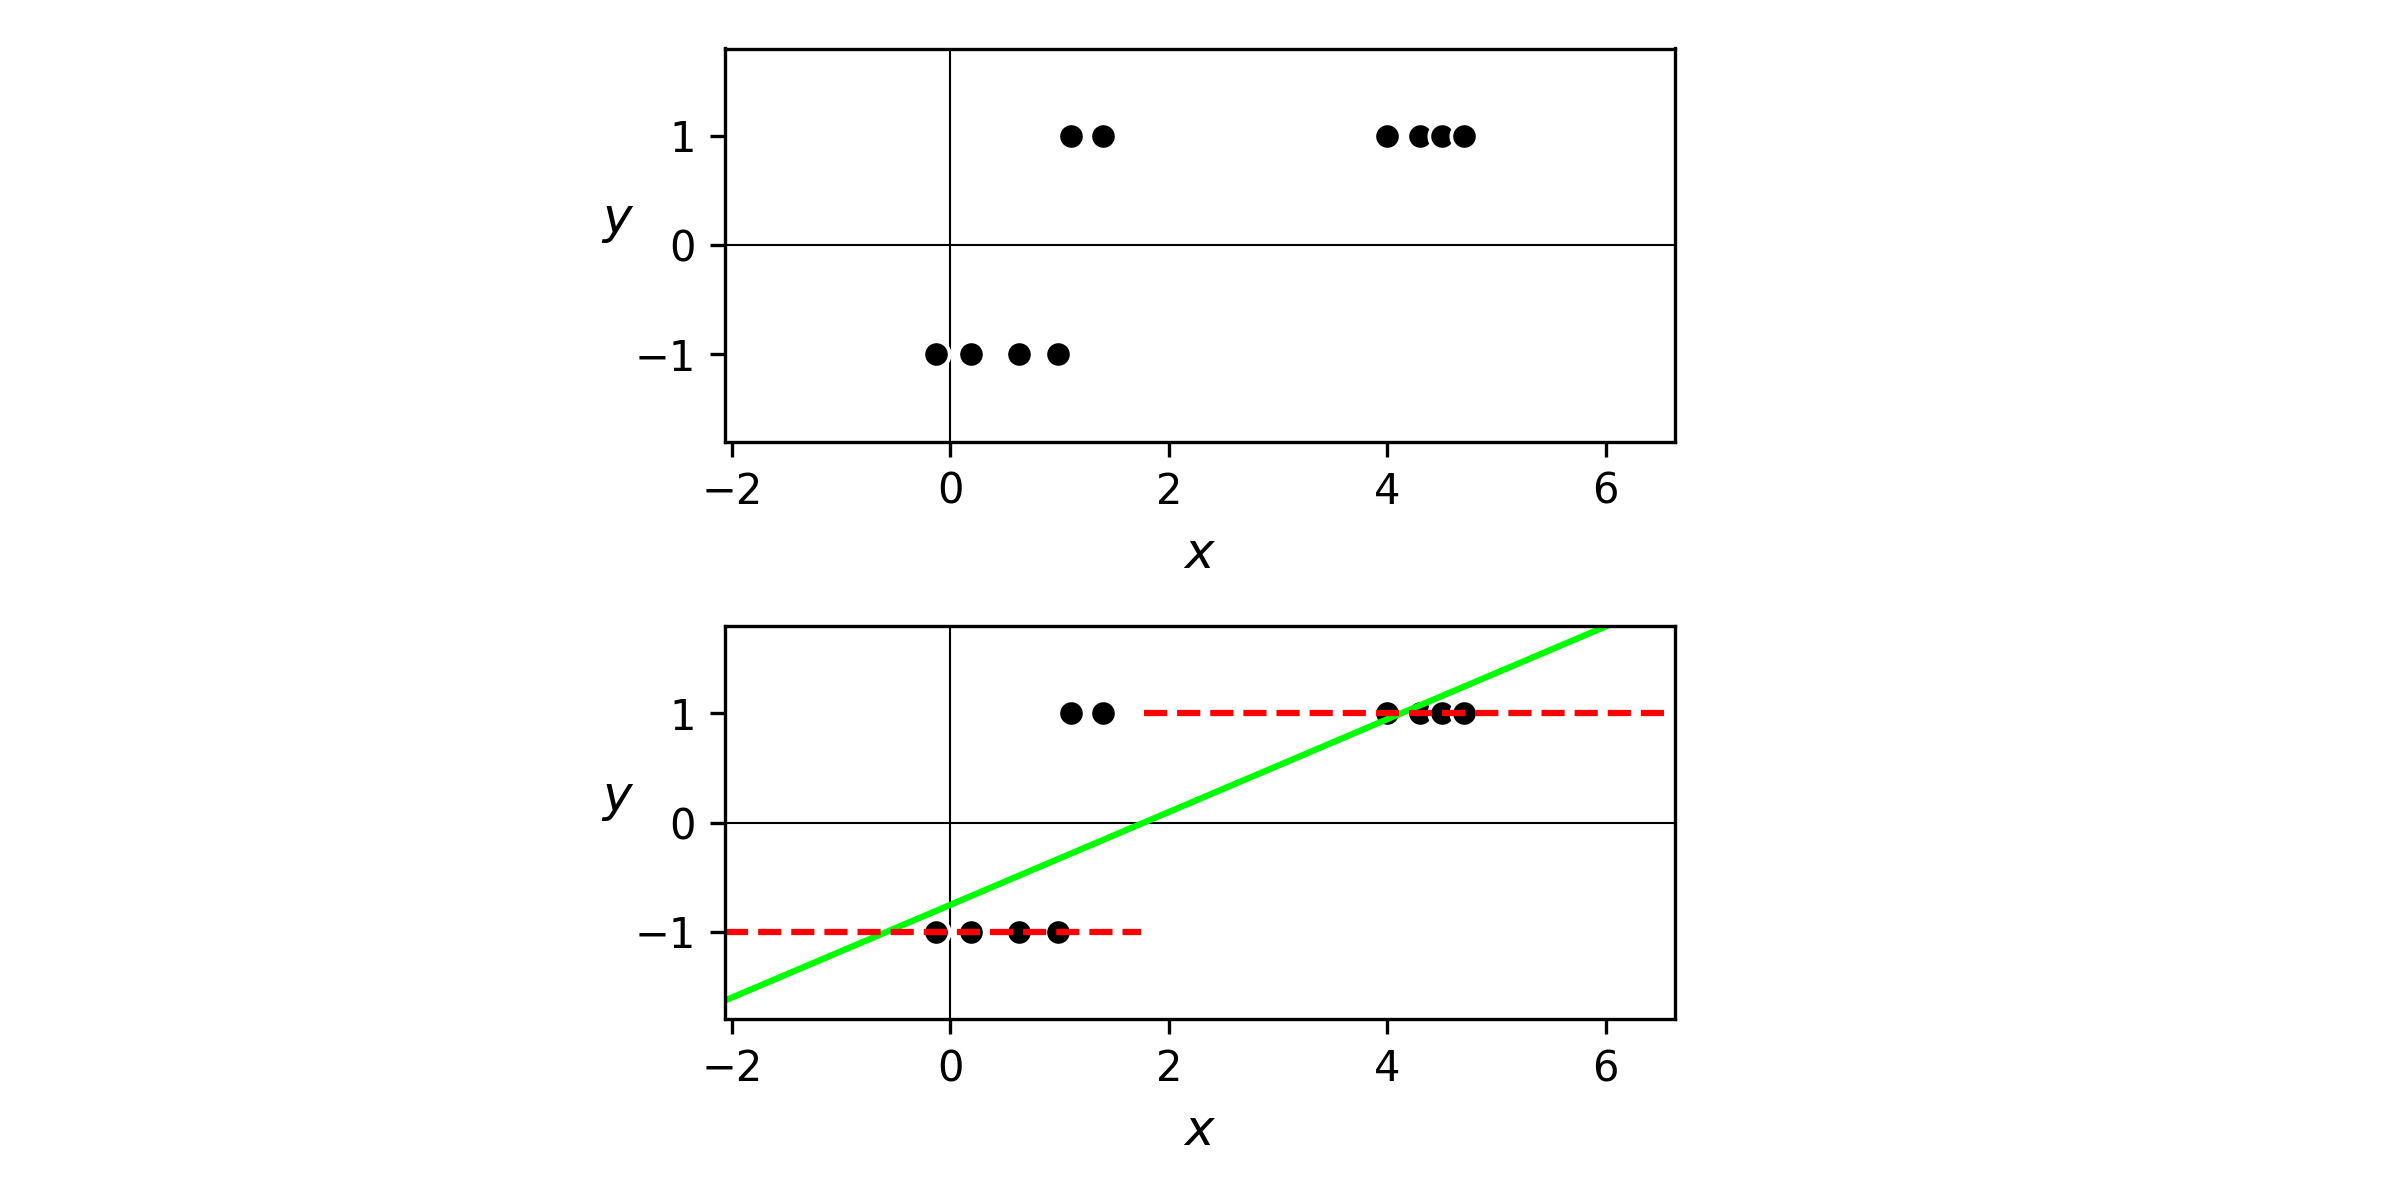

In [7]:
# load in dataset
data = np.loadtxt('../../../mlrefined_datasets/superlearn_datasets/2d_classification_data_v1.csv')

# create instance of linear regression demo, used below and in the next examples
demo1 = superlearn.logistic_regression_simple_demos.visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

- We need to tune the parameters of $\text{sign}\left(w_0 + x_{\,}w_1 \right)$.

- How? we can try to setup a proper Least Squares function.

- Take a single point $\left(x_p,\,y_p \right)$. We would ideally like for its evaluation to match its label value

\begin{equation}
\text{sign}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

- And of course we would like this to hold for every point

\begin{equation}
g(w_0,w_1) = \sum_{p=1}^P \left(\text{sign}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

#### <span style="color:#a50e3e;">Example 2: </span> Visualizing the counting cost on a simple dataset

<IPython.core.display.Javascript object>


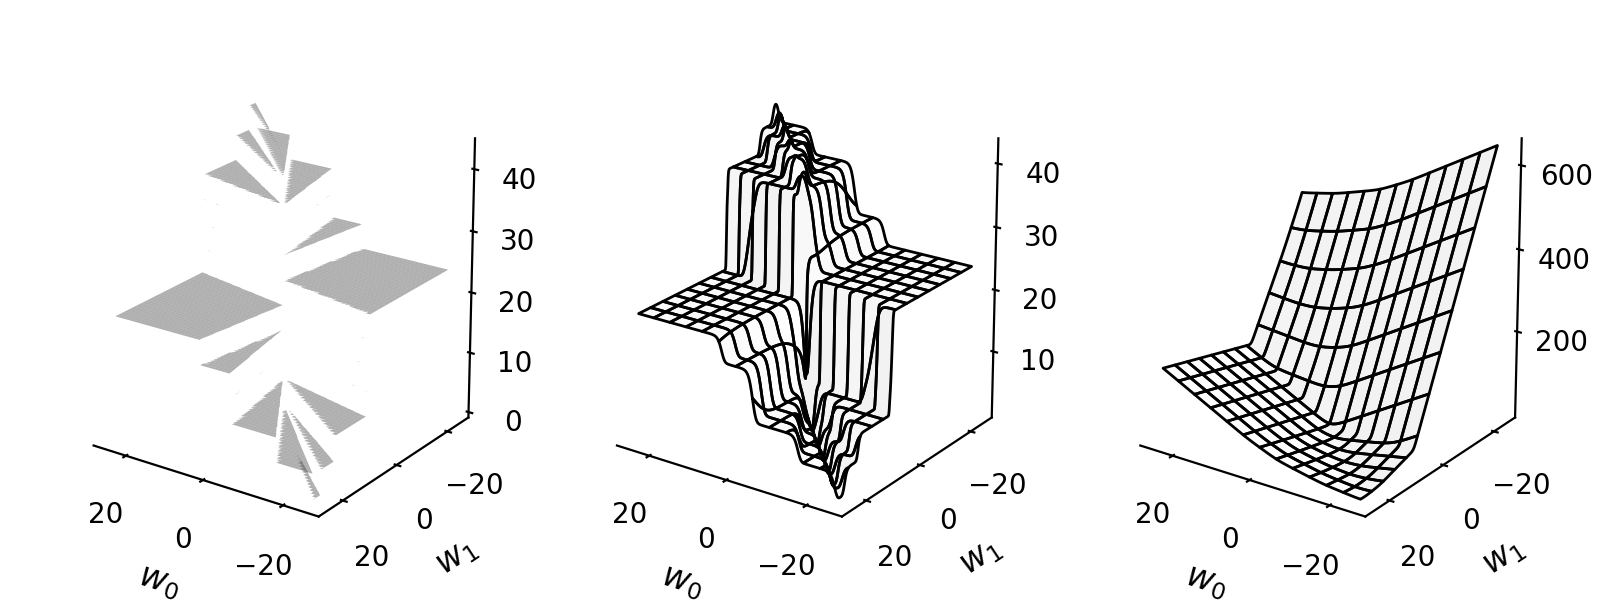

In [39]:
# create an instance of the visualizer and plot
demo2 = superlearn.cost_viewer.Visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

## 1.2  Introducing the hyperbolic tangent function and a logistic Least Squares

- We cannot directly fit a *discontinuous* step function to our data.

<p><img src= '../../../mlrefined_images/superlearn_images/Fig_4_11_new.png' width="80%" height="80%"/></p>

Swapping out the sign function with tanh

\begin{equation}
\text{tanh}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

Using the same logic we can form the following Least Squares cost for *logistic regression*

\begin{equation}
g(w_0,w_1) = \sum_{p=1}^P \left(\text{tanh}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

This cost function can indeed be minimized using local methods, but it is non-convex and contains large flat regions which limits our choice of algorithms to *normalized gradient descent*.

#### <span style="color:#a50e3e;">Example 3: </span> Using normalized gradient descent to perform logistic regression using the Least Squares cost

In [ ]:
# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

# tanh non-convex logistic least squares cost function
def tanh_least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost +=(np.tanh(w[0] + w[1]*x_p) - y_p)**2
    return cost


# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = tanh_least_squares,w = np.asarray([3.0,3.0]),version = 'normalized',max_its = 25, alpha = 1)


# create instance of logisic regression demo and load in data, cost function, and descent history
demo3 = superlearn.classification_2d_demos.Visualizer(data,tanh_least_squares)

# animate descent process
demo3.animate_run(w_hist,num_contours = 25,viewmax = 4.5)

- The zig-zagging behavior is common for gradient descent when running down long narrow valleys, in particular when using the normalized form with fixed steplength.

- If we run long enough, we eventually converge!

<IPython.core.display.Javascript object>


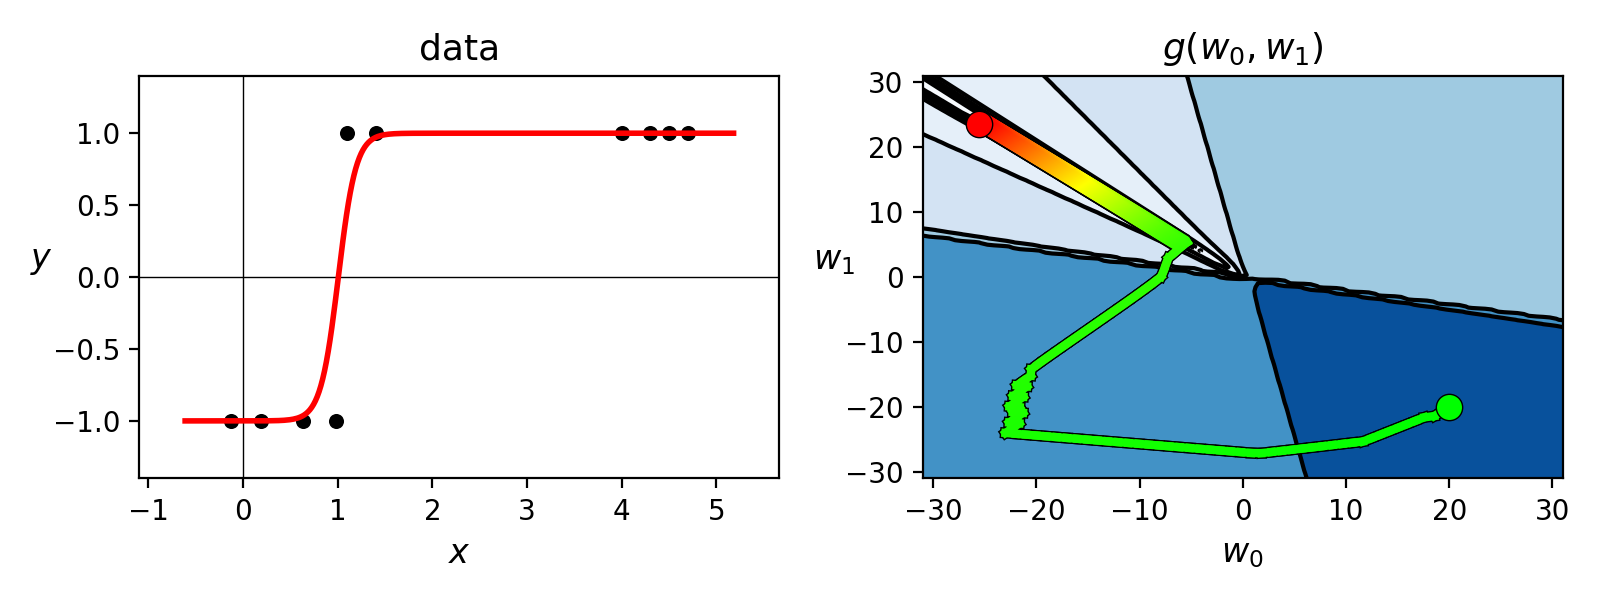

In [44]:
desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = tanh_least_squares,w = np.asarray([20.0,-20.0]),version = 'normalized',max_its = 900, alpha = 1)

# create a static figure illustrating gradient descent steps 
demo3.static_fig(w_hist,num_contours = 25,viewmax = 31)

## 1.3  The convex logistic regression 

Recall our desired equality for the $p^{th}$ point

\begin{equation}
\text{tanh}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

Because tanh is an *odd* function - that is $\text{tanh}\left(s\right) = -\text{tanh}\left(-s\right)$ for all $s$ - and because $y_{p}\in\left\{ -1,\,+1\right\}$, we can write this as

\begin{equation}
\text{tanh}\left(y_p\left(w_0 + xw_1\right)\right) = 1
\end{equation}

Now we can use the exponential definition of tanh, $\text{tanh}\left(s\right) = \frac{2}{1 + e^{-s}}-1$ to rewrite each desired equality equivalently as 

\begin{equation}
1 + e^{-y_p\left(w_0 + xw_1\right)} = 1
\end{equation}

From there we could either subtract one off of both sides to give equivalently

\begin{equation}
e^{-y_p\left(w_0 + xw_1\right)} = 0
\end{equation}

or take the log of both sides to give

\begin{equation}
\text{log}\left(1 + e^{-y_p\left(w_0 + xw_1\right)}\right) = 0
\end{equation}

Both options provide an equivalent way of expressing the desired equality, are nonnegative, and can be used to form convex cost functions for logistic regression.

e.g., the latter expressions gives the commonly used *softmax* (also called the *log-loss*) cost function

\begin{equation}
g\left(w_0,w_1\right) = \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + x_pw_1\right)}\right)
\end{equation}

- The softmax cost function is convex, so we can apply (unnormalized) gradient descent (and other algorithms) more easily

- For all these reasons, the softmax cost is more widely used in practice for logistic regression than the logistic Least Squares cost.

#### <span style="color:#a50e3e;">Example 4: </span> Using unnormalized gradient descent to perform logistic regression using the softmax cost

In [10]:
# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

# the convex softmax cost function
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost += np.log(1 + np.exp(-y_p*(w[0] + w[1]*x_p)))
    return cost


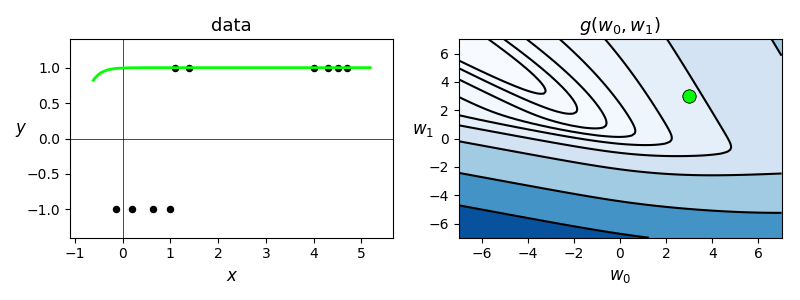
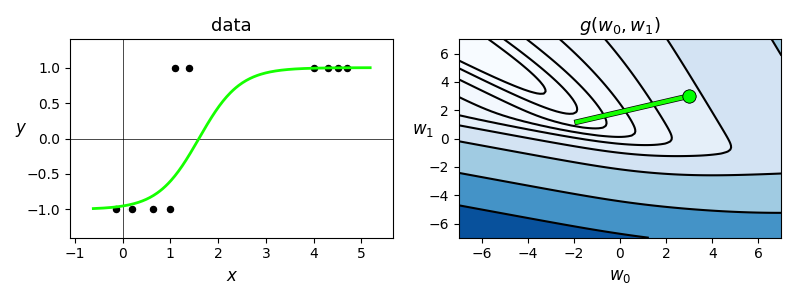
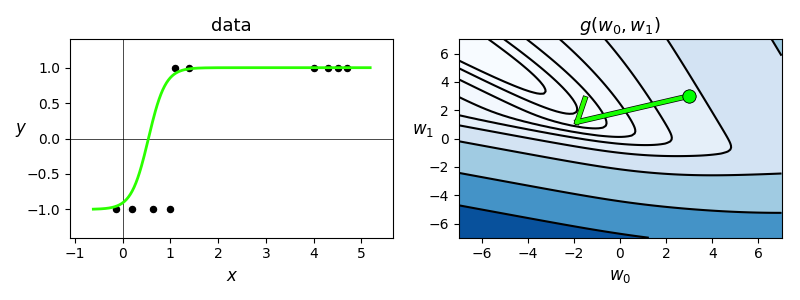
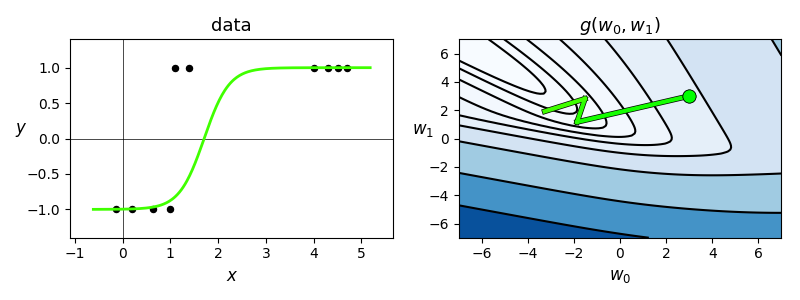
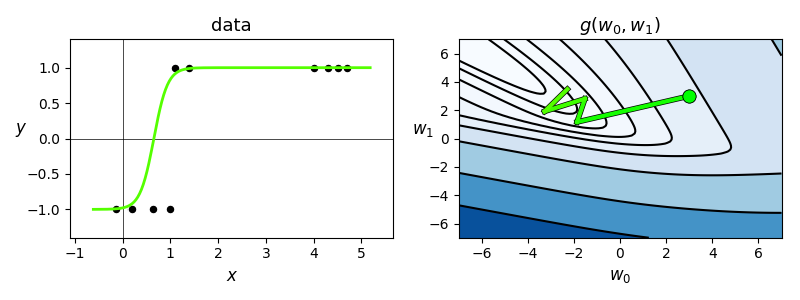
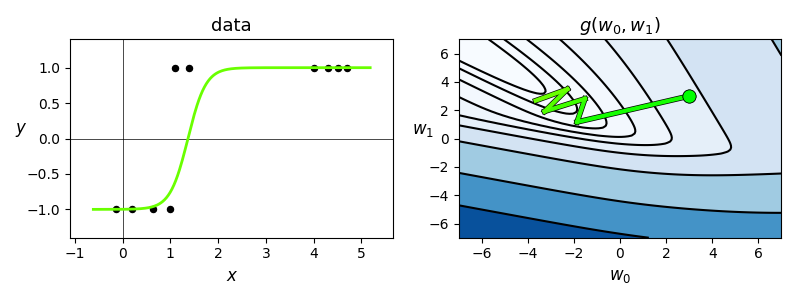
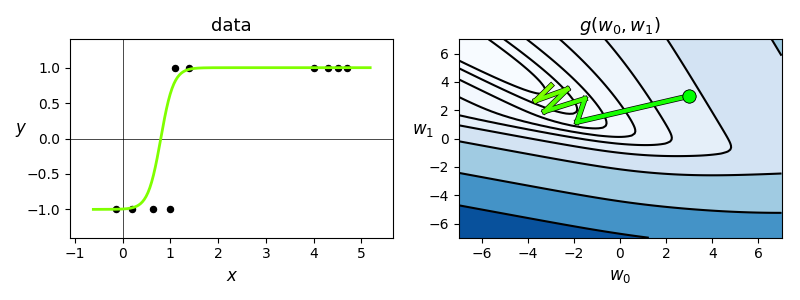
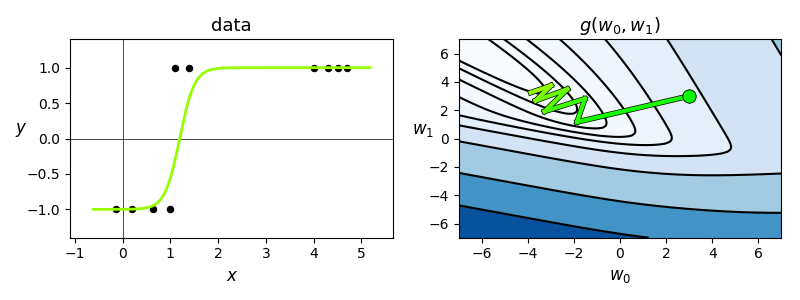
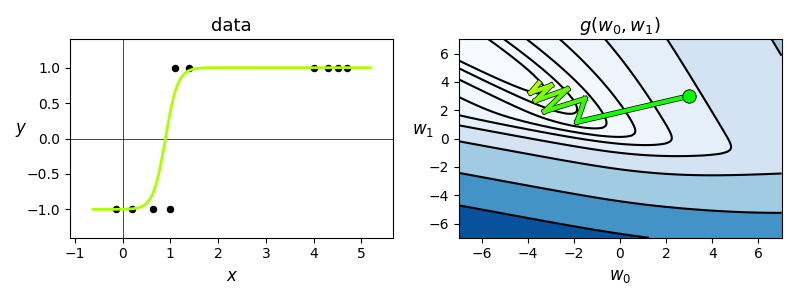
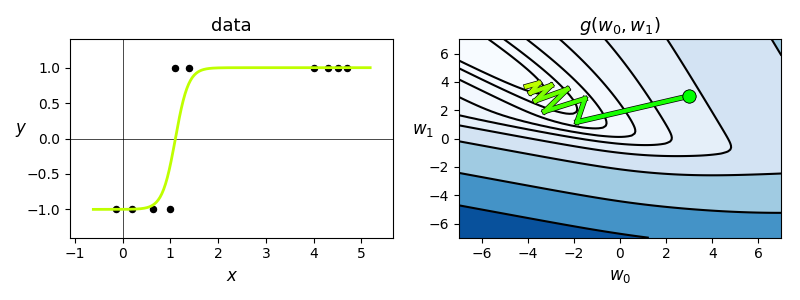
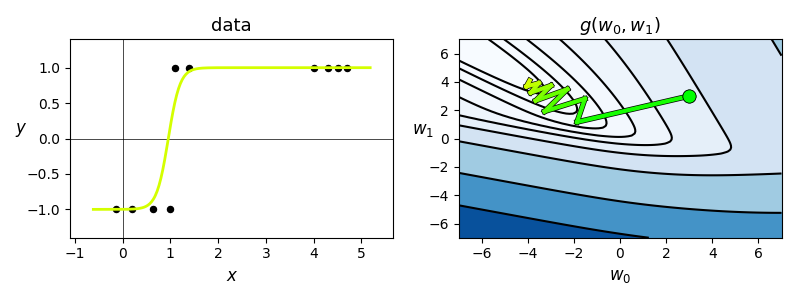
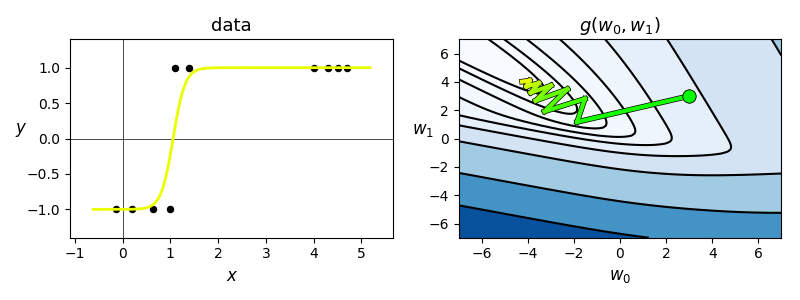
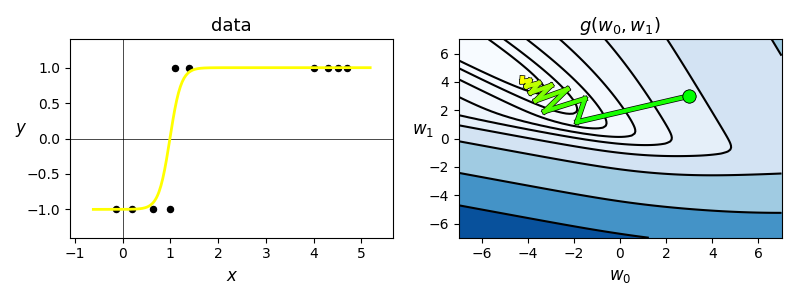
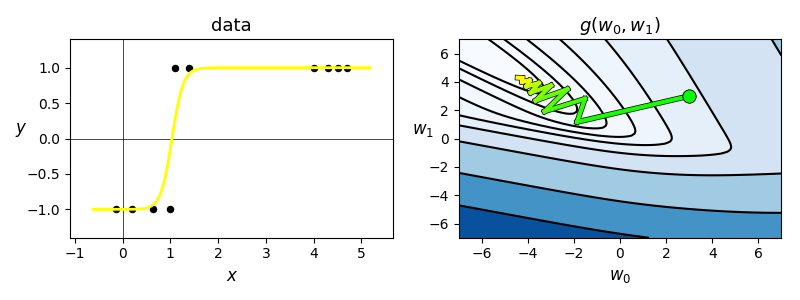
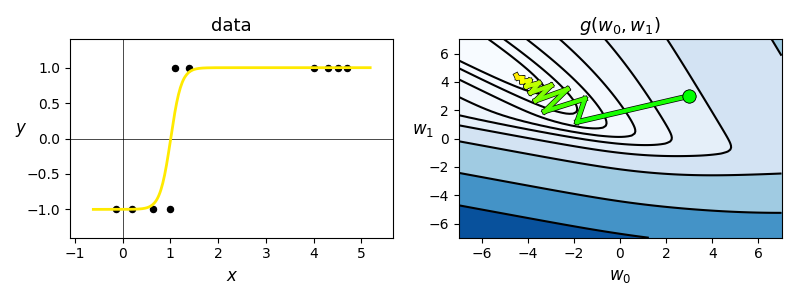
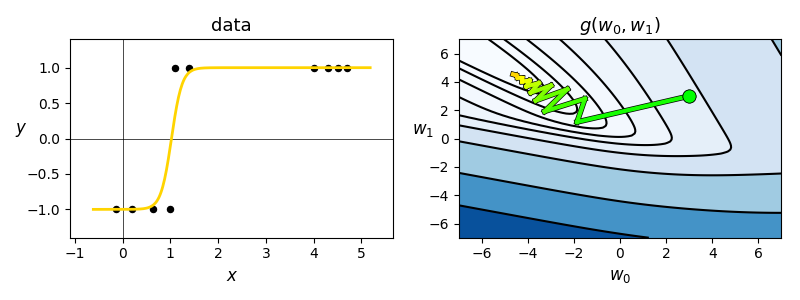
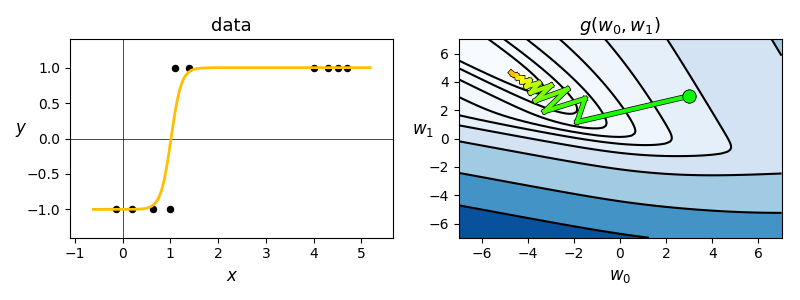
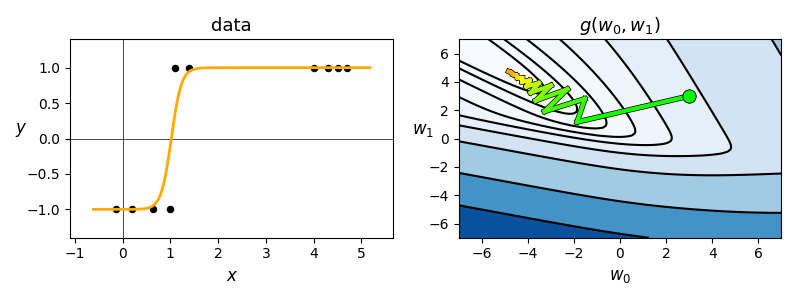
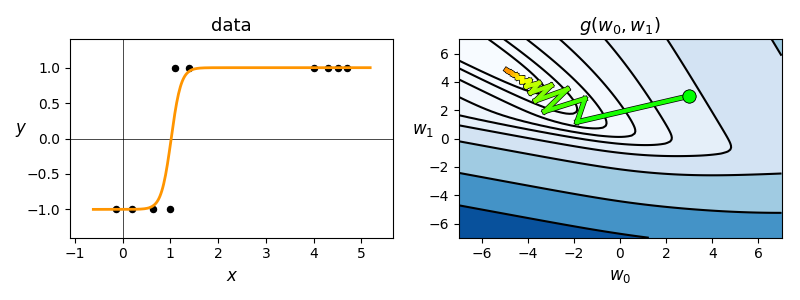
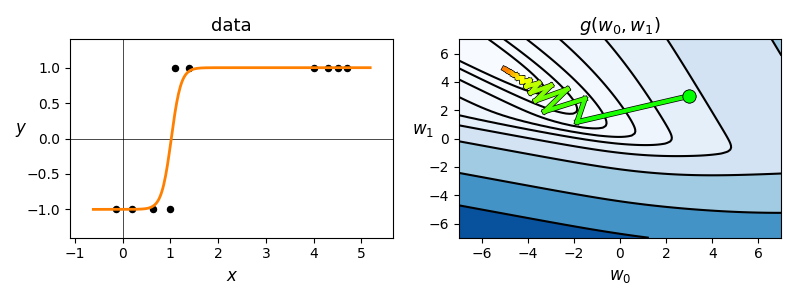
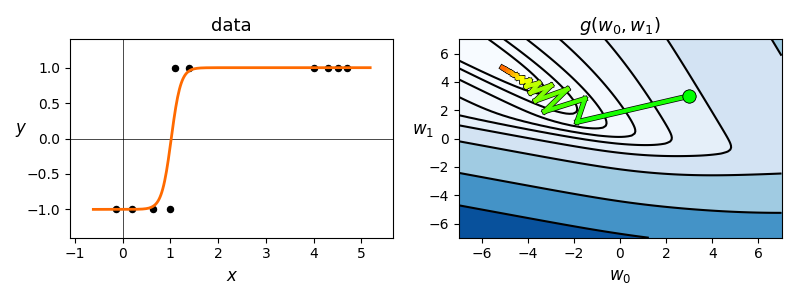
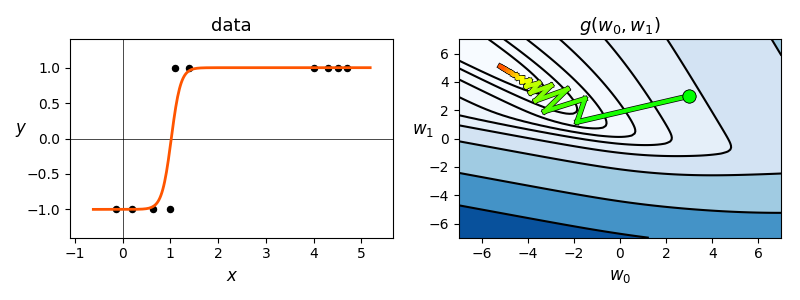
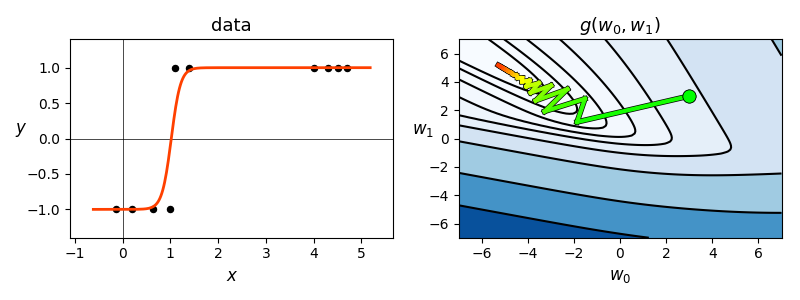
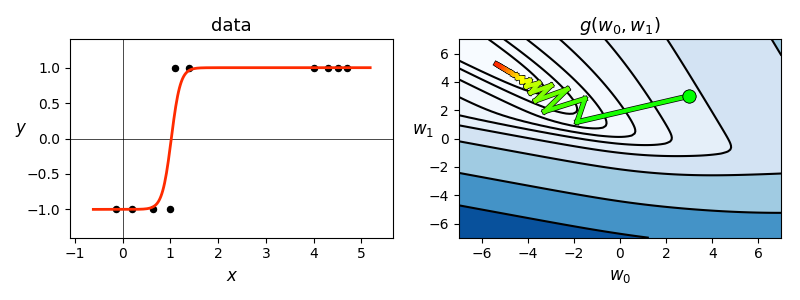
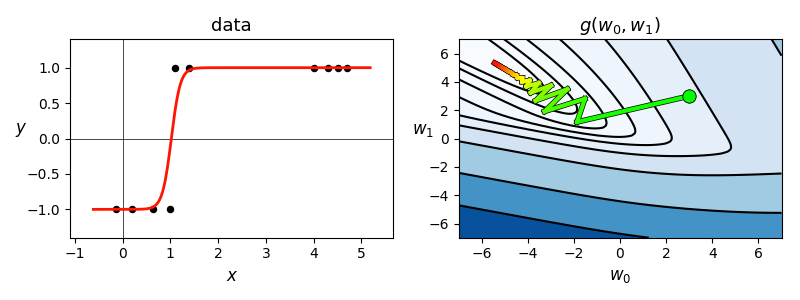
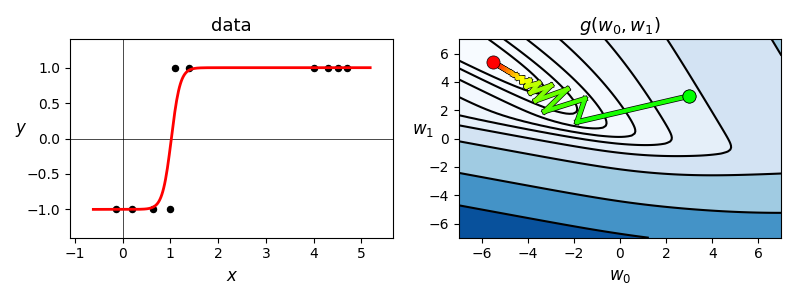

In [11]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = softmax,w = np.asarray([3.0,3.0]),version = 'unnormalized',max_its = 25, alpha = 1)

# create instance of logisic regression demo and load in data, cost function, and descent history
demo4 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# animate descent process
demo4.animate_run(w_hist,num_contours = 25,viewmax = 7)

#### <span style="color:#a50e3e;">Example 5: </span> Using Newton's method to perform logistic regression using the softmax cost

<IPython.core.display.Javascript object>


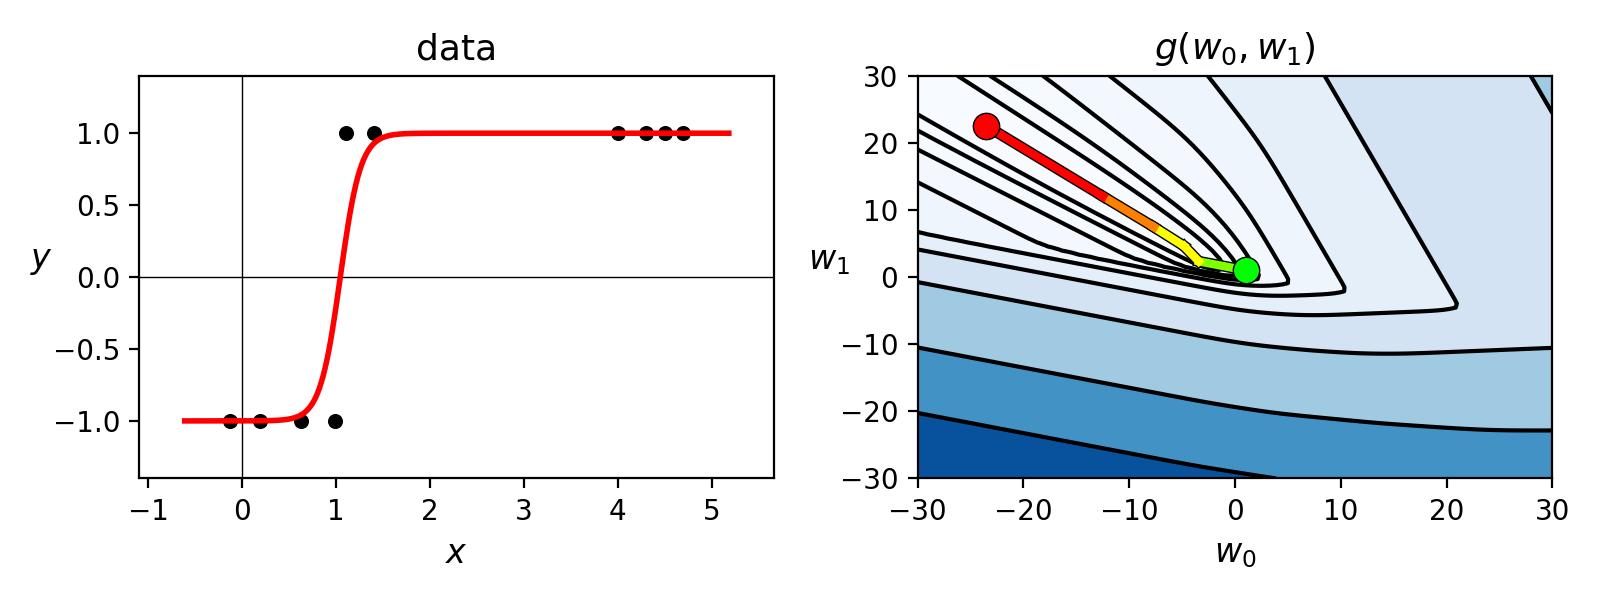

In [48]:
# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = np.asarray([1.0,1.0]),max_its = 5)

# create a static figure illustrating newton's method steps 
demo4.static_fig(w_hist,num_contours = 25,viewmax = 30)

### How about when $N>1$?

Using the same logic that led us to the softmax cost when $N = 1$, we can derive the same set of desired equalities more generally with $N>1$ inputs  

\begin{equation}
\text{log}\left( 1 + e^{-y_p\left(w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots +x_{N,p}w_{N}\right)} \right)  = 0
\end{equation}

Using the more compact vector notation

\begin{equation}
\mathbf{w}=\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{array}\right]
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathbf{x}_p=\left[\begin{array}{c}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{array}\right]
\end{equation}

we can write the above more compactly via the *inner product* as

\begin{equation}
\text{log}\left(1 + e^{-y_p^{\,}\left(w_0+\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}\right)}\right)  = 0
\end{equation}

### Softmax for general $N$

\begin{equation}
g(w_0,\mathbf{w}) = \sum_{p=1}^P\text{log}\left(1 + e^{-y_p^{\,}\left(w_0+\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}\right)}\right)
\end{equation}

- While logistic regression fits a nonlinear surface to classification data in the input-output space, the decision boundary in the input space is always linear - a hyperplane defined by

\begin{equation}
w_0+\mathbf{x}^T \mathbf{w}_{\,}=0
\end{equation}

- Hence logistic regression is considered a *linear classifier*.

<p><img src= '../../../mlrefined_images/superlearn_images/Fig_4_10_new.png' width="80%" height="60%" alt=""/></p>

#### <span style="color:#a50e3e;">Example 6: </span> Constrained and regularized logistic regression

In applying Newton's method to minimize softmax we must be careful not to take too many steps.

<IPython.core.display.Javascript object>


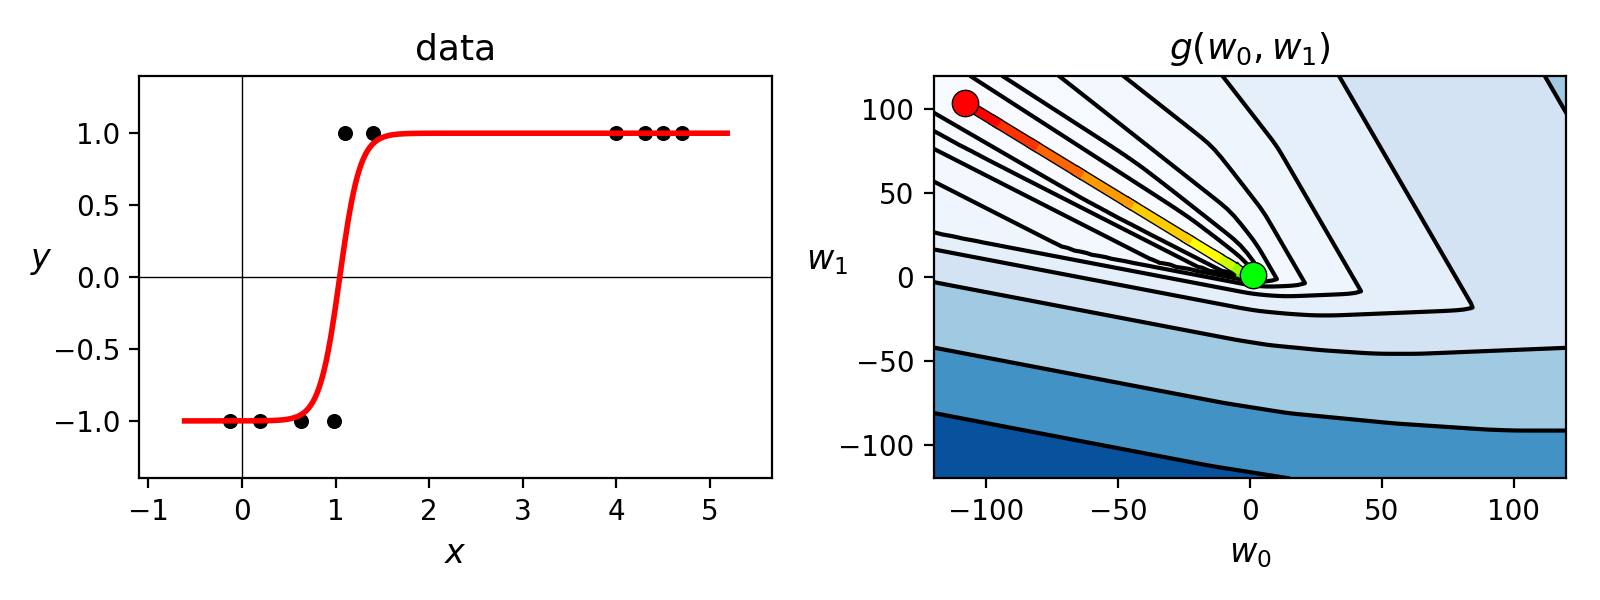

In [50]:
# the convex softmax cost function - for N > 2
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p)) 
    return cost 

# load in demo
demo5 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.
w_hist = opt.newtons_method(g = softmax,w = np.asarray([1.0,1.0]),max_its = 10)

# create a static figure illustrating newton's method steps 
demo5.static_fig(w_hist,num_contours = 25, viewmax = 120)

- A general way to deal with this issue is to make sure the normal vector of the separating hyperplane has unit length

\begin{equation}
\begin{aligned}
\underset{w_0,\,\mathbf{w}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p^T \mathbf{w}\right)}\right)\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w} \right \Vert_2^2 = 1
\end{aligned}
\end{equation}

- One way of solving this problem is to *relax* the problem, forming the *regularized* form of logistic regression

\begin{equation}
\underset{w_0,\,\mathbf{w}}{\text{minimize}} \,\,\, \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p \mathbf{w}\right)}\right) + \lambda\, \left \Vert \mathbf{w} \right \Vert_2^2 \\
\end{equation}

<IPython.core.display.Javascript object>


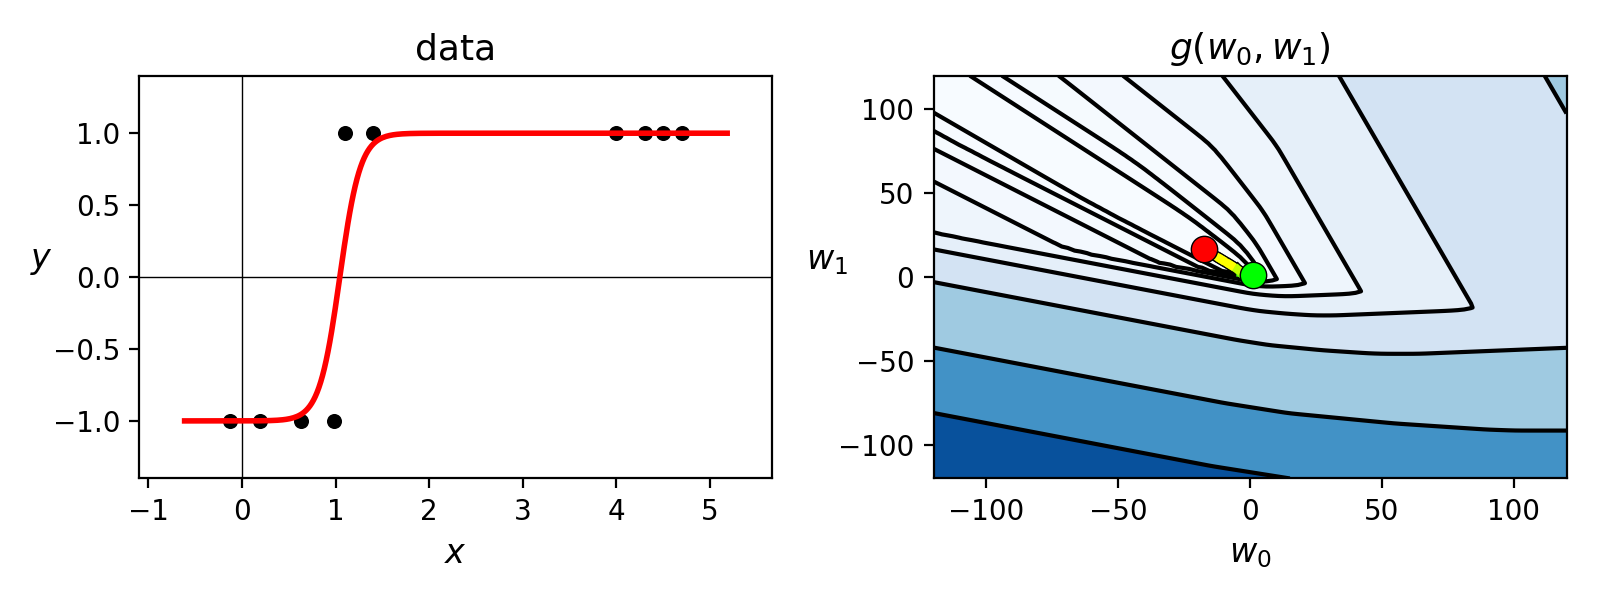

In [52]:
# the convex softmax cost function - for N > 2
lam = 10**(-3)
def regularized_softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p)) 
    return cost + lam*sum([a**2 for a in w[1:]])\

# load in demo
demo6 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.
w_hist = opt.newtons_method(g = regularized_softmax,w = np.asarray([1.0,1.0]),max_its = 10)

# create a static figure illustrating newton's method steps 
demo6.static_fig(w_hist,num_contours = 25,viewmax = 120)

#### <span style="color:#a50e3e;">Example 7: </span>  Noisy classification datasets are so typical they are almost the norm 

<IPython.core.display.Javascript object>


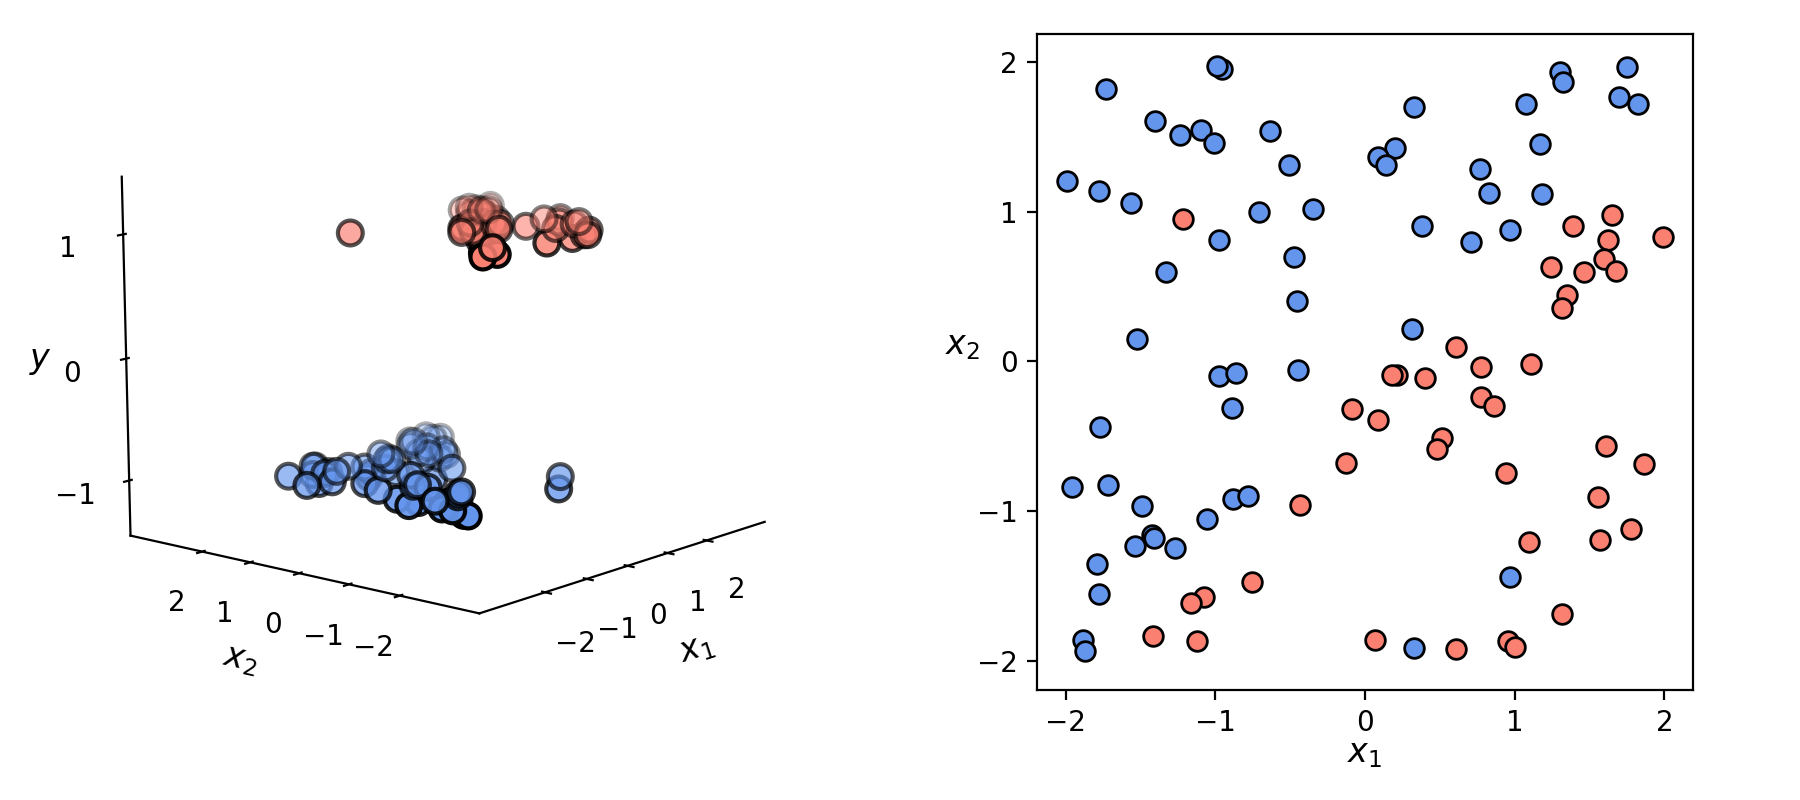

In [8]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v0.csv',delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo7 = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo7.plot_data(view = [15,-140])

In the context of classification a 'noisy' point is one that has an incorrect label (noisy datasets are very common in practice).  

<IPython.core.display.Javascript object>


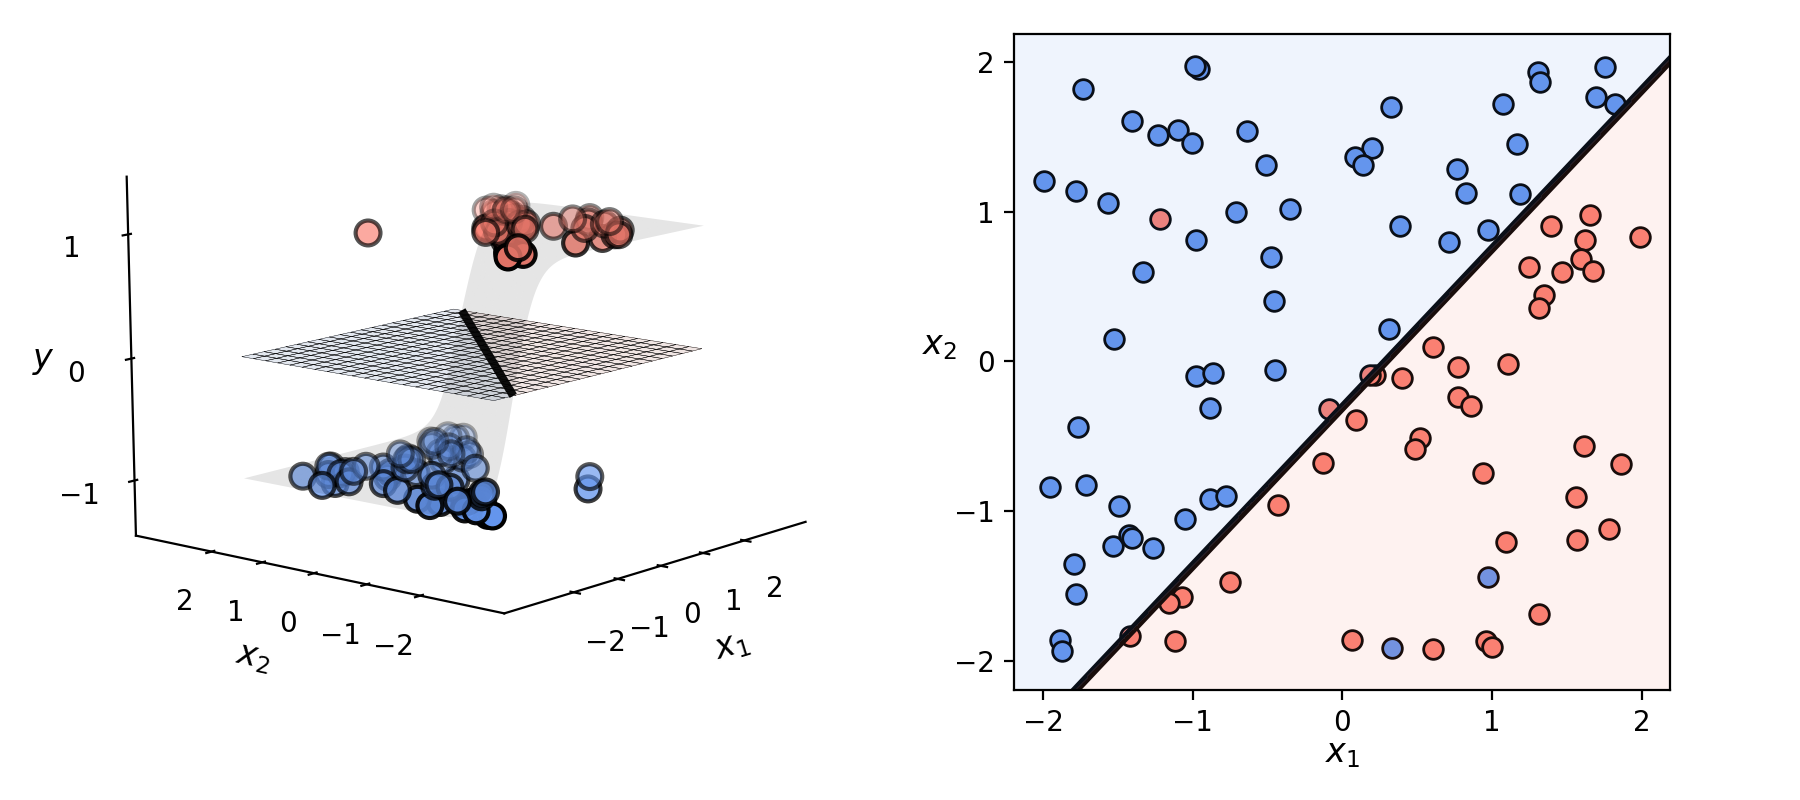

In [26]:
# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

# the convex softmax cost function - for N > 2
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p))
    return cost

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = np.random.randn(3,1),max_its = 5)

# create instance of 3d demos
demo8 = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo8.static_fig(w_hist,view = [15,-140])

### Another noisy example

<IPython.core.display.Javascript object>


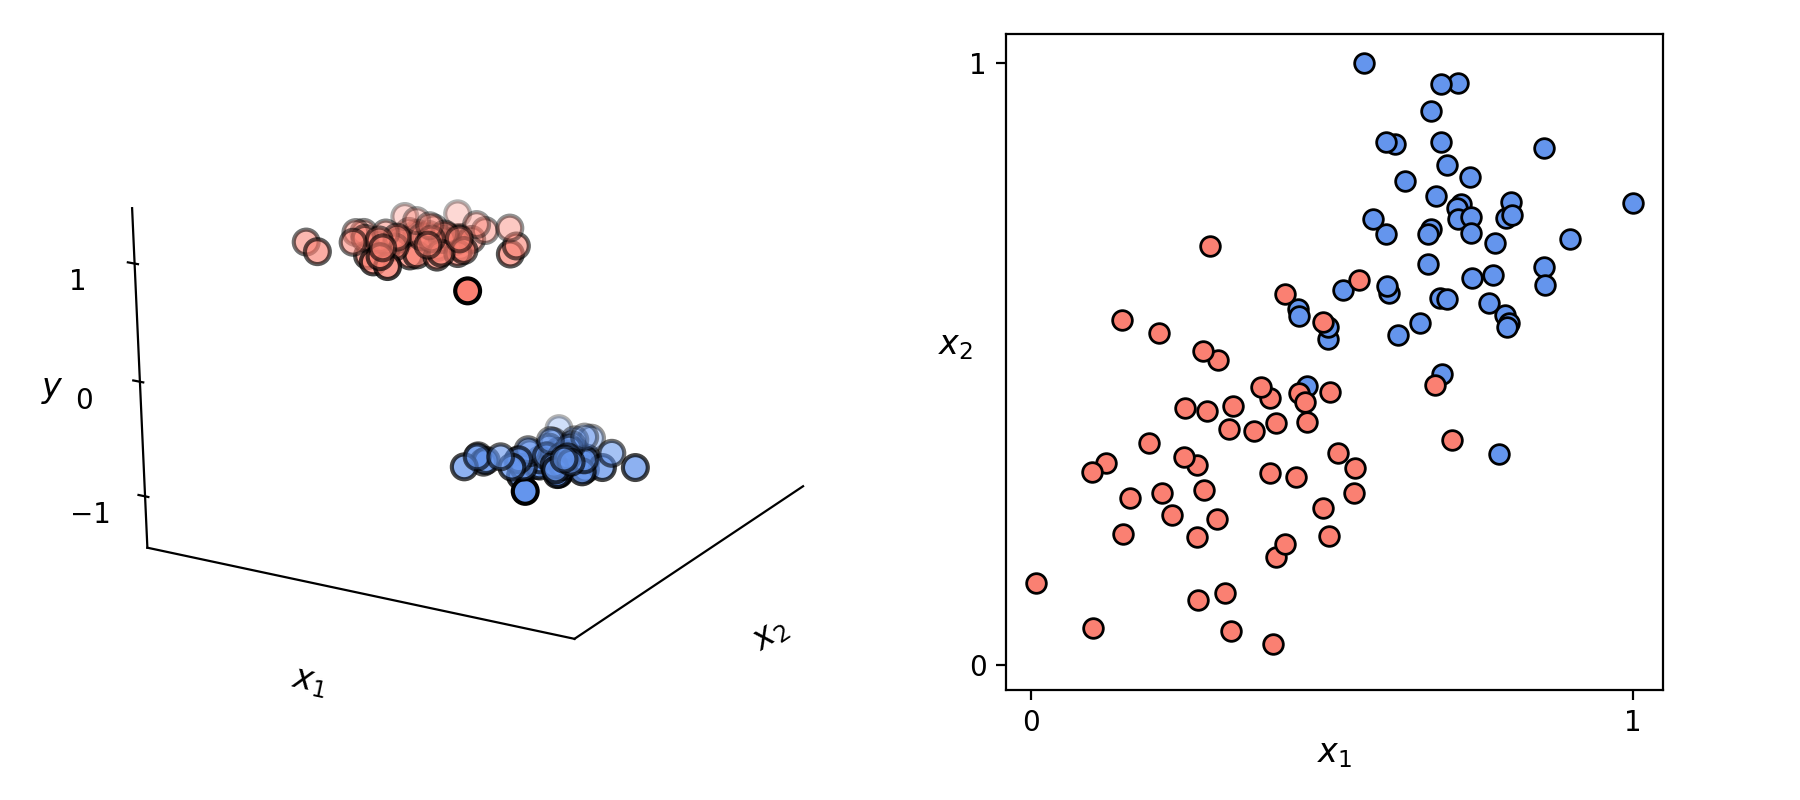

In [28]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v2.csv',delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo9 = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo9.plot_data(view = [25,-60])

<IPython.core.display.Javascript object>


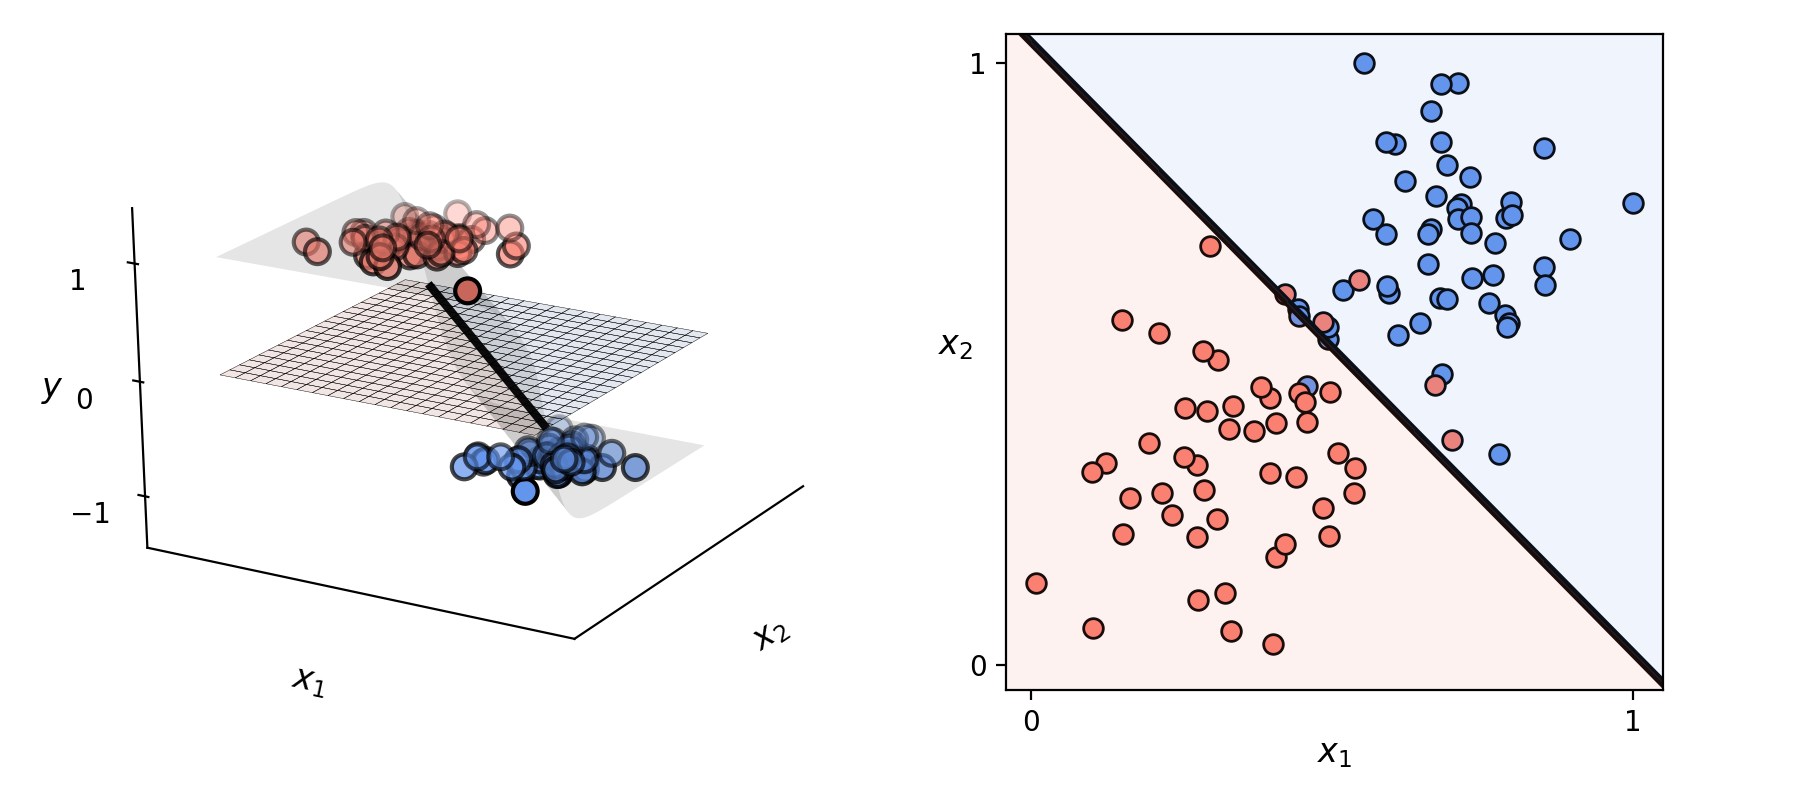

In [31]:
# define the input and output of our dataset - assuming arbitrary N > 1 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = np.random.randn(3,1),max_its = 5)

# create instance of 3d demos
demo10 = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo10.static_fig(w_hist,view = [25,-60])

#### <span style="color:#a50e3e;">Example 8: </span>  Closed form computation of gradient and Hessian for softmax cost function

Using the more compact notation

\begin{equation}
\widetilde{\mathbf{w}}=\left[\begin{array}{c}
w_{0}\\
\mathbf{w}
\end{array}\right]
\,\,\,\,\text{and}\,\,\,\,\,
\widetilde{\mathbf{x}}_{p}=\left[\begin{array}{c}
1\\
\mathbf{x}_{p}
\end{array}\right]
\end{equation}

one can easily compute the general form of the gradient by hand to be

\begin{equation}
\nabla g\left(\widetilde{\mathbf{w}}\right) = - \sum_{p = 1}^P \frac{e^{-\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}{1 + e^{-\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}\, y_p^{\,} \widetilde{\mathbf{x}}_p^{\,}
\end{equation}

which is often written equivalently as

\begin{equation}
\nabla g\left(\widetilde{\mathbf{w}}\right) = - \sum_{p = 1}^P \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}\, y_p^{\,} \widetilde{\mathbf{x}}_p^{\,}
\end{equation} 

To avoid numerical problems.

For the same reasons the Hessian of the softmax (for use with Newton's method) is often written as

\begin{equation}
\nabla^2 g\left(\widetilde{\mathbf{w}}\right) =  \sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \, \widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T
\end{equation}

## 1.4  Classification nomenclature and predictions

<p><img src= '../../../mlrefined_images/superlearn_images/Fig_4_6_new.png' width="85%" height="80%" alt=""/></p>

## 1.5  Counting misclassifications and the accuracy of a trained classifier

Because $y_p \in \{\pm 1\}$ 

\begin{equation}
\left(\text{sign}\left(w_0+\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) - y_p \right)^2 = \begin{cases}
0 \,\,\,\, \text{if} \,\,\,\text{sign}\left(w_0+\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) =  y_p \\
4 \,\,\,\, \text{else} \\
\end{cases}
\end{equation}

Therefore to count the total number of misclassifications of a trained classifier we can simply evaluate the counting cost, dividing by $4$ as 

\begin{equation}
\text{number of misclassifications} = \frac{1}{4}\sum_{p=1}^P \left(\text{sign}\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

#### <span style="color:#a50e3e;">Example 9: </span> Comparing the softmax cost and the counting cost

<IPython.core.display.Javascript object>


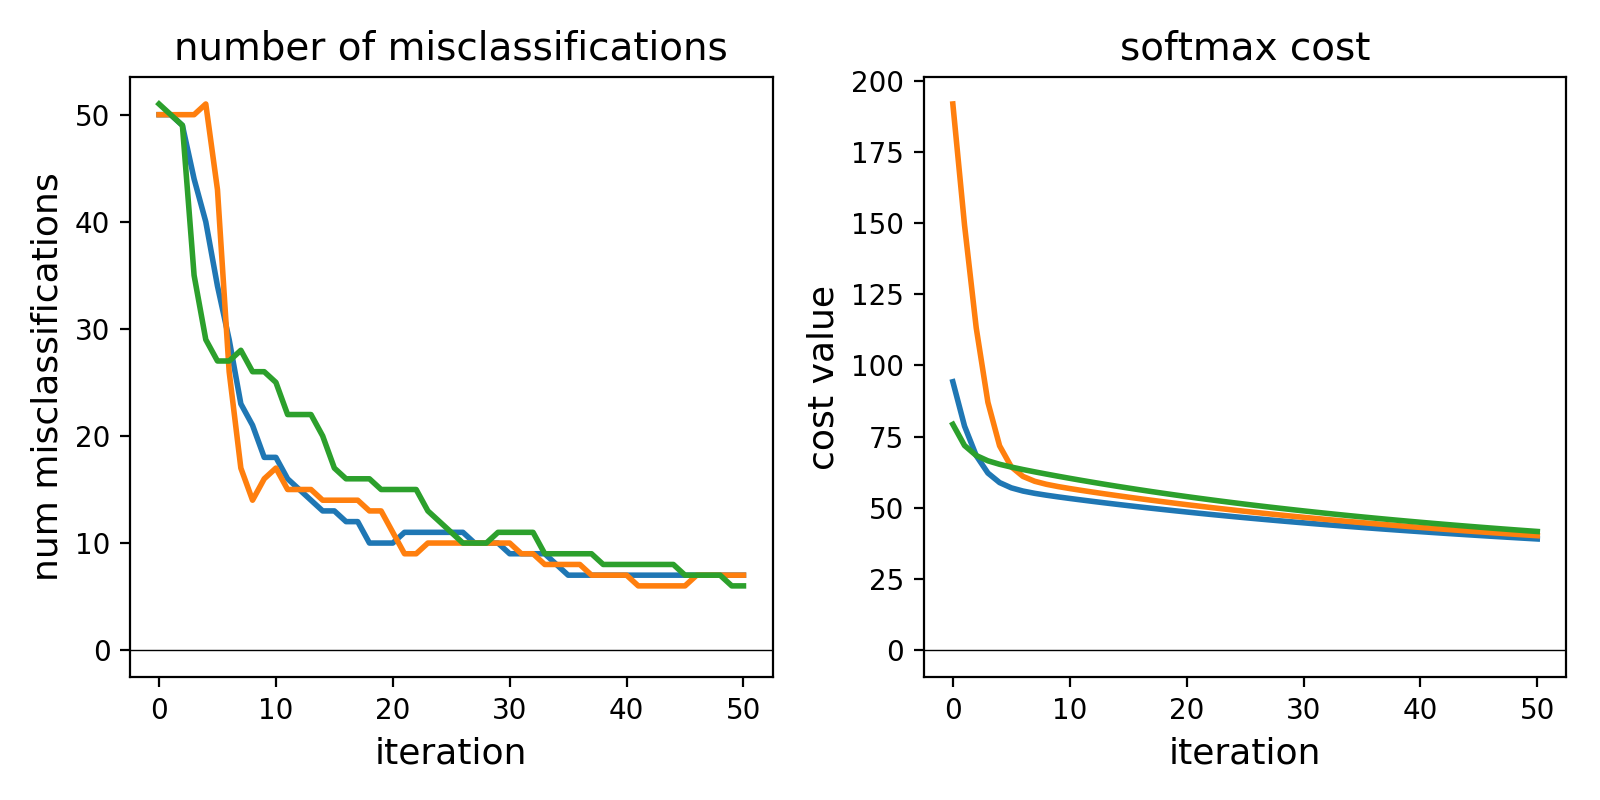

In [32]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v2.csv',delimiter = ',')

# create instance of cost comparison demo
demo11 = superlearn.cost_comparisons.Visualizer(data)

# run 
demo11.compare_to_counting(cost = 'softmax',max_its = 50,num_runs = 3,alpha = 10**-2,algo = 'gradient_descent')

Note: during optimization one should save the weight associated with the lowest *number of misclassifications* not the lowest cost value.

The simplest measure of how well a classifier has been trained on a set of $P$ training datapoints is its *accuracy*

\begin{equation}
\text{accuracy}= 1 - \frac{1}{4P}\sum_{p=1}^P \left(\text{sign}\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

which ranges from 0 (no points classified correctly) to 1 (all points classified correctly).

## 1.6 Logistic regression from a probabilistic perspective

As with linear regression, we again make the assumption that the datapoints are statistically independent of each other 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation}  

Replacing $-1$ labels with $0$, so that $y_p \in\left\{0,1\right\}$, we can write each product term in the likelihood compactly as

\begin{equation}
{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)={\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\,{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{1-y_p}
\end{equation} 

Since $y_p$ takes only one of two values, we have that 

\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)= 1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation} 

giving the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\left[1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

Now what is ${\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)$? 

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\begin{cases}
1 \,\,\,\,\,\text{if} \,\, w_0+\mathbf{x}_p^T\mathbf{w}>0 \\
0 \,\,\,\,\,\text{else} \\
\end{cases}
\end{equation}

Problem: any misclassification will send the entire likelihood to zero.

Solution: we can use the logistic sigmoid function $\sigma(\cdot)$ as a strictly positive approximation to the 0/1 step function

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)
\end{equation} 

which gives the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)^{y_p}\left[1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

and the corresponding negative log-likelihood - also referred to as the cross-entropy loss - as 


\begin{equation}
g\left(w_0,\mathbf{w}\right)=-\sum_{p=1}^{P}y_p\,\text{log}\,\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)+\left(1-y_p\right)\text{log}\,\left(1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right)
\end{equation}  

The maximum likelihood approach to logistic regression leads to the cross-entropy loss, which is equivalent to the softmax cost with $\pm 1$ labels.

The notion of class probability is closely connected to the geometric notion of distance to the decision boundary.


<p><img src= '../../../mlrefined_images/superlearn_images/distance_to_boundary.png' width="70%" height="80%" alt=""/></p>

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0^{\star},\mathbf{w}^{\star}\right)=\sigma\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}\right)
\end{equation} 

- The farther a point is from the decision boundary the more confident the classier becomes about its predicted label. 

- Conversely, as we get closer to the boundary, the classifier loses 'confidence' and the probability scores for each class get closer in value.